# Optuna Demo
***
Steven Glover <br>
cscie89 - Deep Learning

# 1. Optuna
## 1.a Hyperparameter selection
One of the most important steps to building a successful deep-learning solution is hyperparameter tuning. The choice of hyperparameters, such as the number of layers, regularization parameters, dropout rate, optimizer selection, learning rate etc. can be the difference between a well-performing product that generalizes well and a high variance model that tanks in production. The motiviation for this notebook is to explore the application of an efficient, effective, and systematic approach to hypter parameter tuning.  
<br>
So, how does one choose a selection of hyperparameters that is optimized to the algorithm and the data? There are several methods one can use to select a combination of parameters for a model:
1. Manually surveying combinations of parameters:  manually experimenting, which is subjective, inefficient, and time-consuming.
2.	Grid search: define a grid of parameters, run every combination of proposed parameters, and choose the selection that optimizes a predefined metric, such as accuracy or r2. Grid search is a costly procedure in terms of time and compute.  
3.	Randomized search: the user defines a range and distribution of parameters and the combinations are searched randomly returning the best selection of parameters. This is much faster than grid search but I find this is often followed up by a much narrow search of the surrounding parameter space.
4.	Hyperparameter tuning frameworks:  There are several options when selecting a hyperparameter optimization framework. Each has pros and cons. Figure 1 illustrates a comparison of features of several popular frameworks.


![picture](https://drive.google.com/uc?export=view&id=11v6Fqh-cCTxYrmN0v6aZt_FNObTAlvcV)

[ <font color=blue> 1 </font> ]


## 1.b Why Optuna
Optuna is a framework for hyperparameter optimization that was designed to fulfil the following criteria, *“(1) define-by-run API that allows users to construct the parameters search space dynamically, (2) efficient implementation of both searching and pruning strategies and (3) easy-to-setup, versatile architecture that can be deployed for various purposes”* [ <font color=blue> 2 </font> ].  In short, Optuna is a framework that automates the hyperparameter selection process by focusing on parameter spaces that perform comparatively well (sampling strategy) and ignoring parameter spaces that don’t (pruning strategy).  Its architecture enables the user to define a search space dynamically (define-by-run) rather than implicitly (define-and-run). Additionally, Optuna provides a several utilities to analyze and report on the search space optimization. In this demonstration, we will define each of these criteria in more detail, explore the features of the Optuna API, and illustrate the practical application of the Optuna framework to create an image classifier for identifying cancerous tumors in ct-scans of the lung.

# 2 Enviornment Set-up
## 2.a Optuna Installation
I am using Google Collab for this project with a T4 GPU.  All the packages needed for this project are installed in the base image except for Optuna. So, let's do a pip install to add it to the environment.

In [ ]:
! pip install optuna-dashboard
! pip install optuna
! pip install optuna-integration

## 2.b Library Import

In [2]:
from google.colab import output
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import os

import os
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import models
from tensorflow.keras import optimizers
import numpy as np

import time
import threading
import optuna
from optuna_dashboard import wsgi
from wsgiref.simple_server import make_server

The io connection between Google Drive and Collab can be painfully slow. An easy workaorund is to zip the images on drive and unzip them in the current workspace.

In [ ]:
! unzip "drive/MyDrive/github/optuna-demo/data/data.zip" -d "/content"

## 2.c GPU Setup for Tensorflow and Optuna
A word of caution, there is a bug when using Optuna and Tensorflow with a GPU. The memory in the GPU quickly inflates with each trial until an out of memory error is recieved. A solution is not documented on any of the go-to dev forums (StackOverflow, GitHub, etc.)  The documentation states that the framework is compatible with ML frameworks that use eager execution. While the default of tensorflow 2 is eager execution, the Model Object compiles a graph before execution. To ensure all operations executed eagerly I set the configuration `run_functions_eagerly` to True, which mitigated the out-of-memory issue I was experiencing. This approach is effective for small scale experiments but additional stragies for managing GPU data leakage will be required for searching a large hyper parameter space.

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.config.run_functions_eagerly(True) #<- very important to manage GPU memory
tf.keras.utils.set_random_seed(0)

# 3. Modeling

## 3.a Objective
The objective of the model is to identify if a cancerous tumor is present in an image of a chest CT scan.  It is a multiple-class problem with three types of cancerous cells and one class of normal cells. Our goal is to correctly label the type of tumor.

## 3.b Data
The images can be obtained on Kaggle using the link provided below.

<br>https://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images
<br>
<br>
We are provided with four image classifications:   adenocarcinoma, large cell carcinoma, squamous cell carcinoma, and normal. The images are labelled and subset into the following folder structure:

In [6]:
for subset in ["train", "valid", "test"]:
  print(subset)
  dirs = os.listdir(f"data/{subset}")
  for dir in dirs:
    print(dir, len(os.listdir(f"data/{subset}/{dir}")))
  print('\n')

train
squamous.cell.carcinoma 155
adenocarcinoma 195
large.cell.carcinoma 115
normal 148


valid
squamous.cell.carcinoma 15
adenocarcinoma 23
large.cell.carcinoma 21
normal 13


test
squamous.cell.carcinoma 90
adenocarcinoma 120
large.cell.carcinoma 51
normal 54




The folder structure is ideal for using the TensorFlow `ImageDataGenerator` classes `flow_from_directory` method to yield batches of processed images for training.

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

validation_generator = valid_datagen.flow_from_directory(
        'data/valid',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        'data/test',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


# 3.c Base Model
We will use CNNs as our learning architecture. To illustrate the effectiveness of Optuna I will create an “Base” model and choose an arbitrary hyperparameter selection and train it for 10 epochs.  We will then use Optuna to create “Challenger” models. Model performance will be evaluated on accuracy.


In [ ]:
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

history = model.fit(
      train_generator,
      steps_per_epoch=len(train_generator),
      epochs=10,
      validation_data=validation_generator,
      validation_steps=len(validation_generator))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


20/20 [==============================] - 13s 212ms/step - loss: 2.7347 - acc: 0.3491 - val_loss: 1.3457 - val_acc: 0.2639
Epoch 2/10
20/20 [==============================] - 5s 246ms/step - loss: 1.2501 - acc: 0.4698 - val_loss: 1.1513 - val_acc: 0.4861
Epoch 3/10
20/20 [==============================] - 6s 294ms/step - loss: 1.0266 - acc: 0.5449 - val_loss: 1.0321 - val_acc: 0.4722
Epoch 4/10
20/20 [==============================] - 4s 205ms/step - loss: 0.9109 - acc: 0.5840 - val_loss: 1.1475 - val_acc: 0.4861
Epoch 5/10
20/20 [==============================] - 5s 259ms/step - loss: 0.8134 - acc: 0.6493 - val_loss: 1.5583 - val_acc: 0.4444
Epoch 6/10
20/20 [==============================] - 4s 220ms/step - loss: 0.7179 - acc: 0.6982 - val_loss: 0.8576 - val_acc: 0.5972
Epoch 7/10
20/20 [==============================] - 6s 312ms/step - loss: 0.6266 - acc: 0.7700 - val_loss: 0.9313 - val_acc: 0.5694
Epoch 8/10
20/20 [==============================] - 4s 197ms/step - loss: 0.4945 - acc

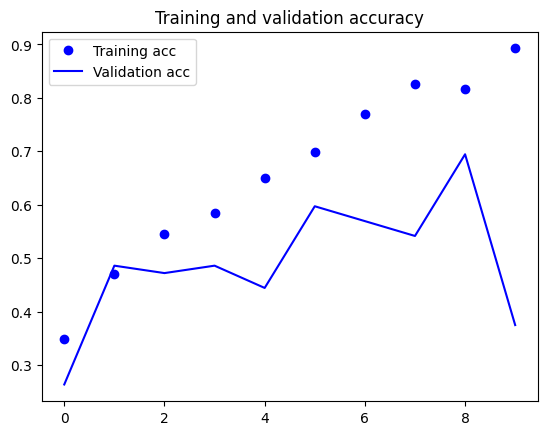

In [ ]:
import matplotlib.pyplot as plt

epochs = history.epoch
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# 4. Simple Introduction to Optuna Framework


 With this simple model architecture, the model began to overfit after the 3th epoch and it was able to achieve a validation accuracy of .694.. Lets use Optuna to explore how we can improve the model. As a simple exmaple, to illustrate the API and its compenents, lets add some drop out to mitigate the overfitting. But how much dropout is optimal for this current architecture.



# 4.a Optuna Compents and Objects
The Optuna Architecture has several different components that work in tandem to optimize, analyze and report on hyperparameter experiments. Before diving into our first example, lets review some of the components and nomenclature.

1. Optuna defines a single test of a selection of hyperparameters as a `Trail`
2. A collection of Trials as a `Study`.
3. The main goal of Optuna is to optimize an `Objective Function` through trail iterations of experiments with samples from the hyper-parameter space. The objective function defines the score that will be optimized.  
4.	The `suggest_x` API is used to define the range or selection of hyperparameters to be sampled for each trial.  The Suggest API has several methods that correspond to the datatype they return. For example, `suggest_categorical` should be used when you are searching a categorical string value such as which activation function to choose [‘relu’, ‘softmax’, ‘tanh’,…] and `suggest_int` would be used to search a range of values that take an integer value, such as the number of layers, number of nodes in a layer, steps for convolution, etc. A complete list of the `suggest_x` API is available in the documentation (https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html).
5.	`Sampling` & `Pruning` are the mechanisms for optimization. The sampler chooses a selection of hyperparameters for a trial and the pruner will kill the trial before it completes if does not rank amongst the highest performing trials. Pruning allows us to use more resources to focus on the successful trials and ignore under-performing search spaces.
  * **Sampling** refers to how hyperparameters are selected. Values are selected from the suggested ranges using a sampling strategy. Optuna surveys a range of values and focuses on the areas where the model performs better. There are various sampling strategies to choose from and the user can also define their own.
  * **Pruning** describes how to kill unsuccessful trials. Optuna monitors intermediate values of the objective function and will stop experiments if they are performing poorly by comparison to other trials. Note: Optuna does not implement pruning by default. The user has to specify if a pruning procedure.
6. Storage – Optuna tracks the study and trial history using a database. Optuna uses sqlite by default but this can be configured to the users specifications.

Let’s look at a very simple implementation of these concepts to get familiar with them before we move on.  Here we will search the number of nodes in the dense layer immediately after our flattening layer. For illustration purposes, I will run 10 tests.

### 4.a.i Create Model
The `create_model` function defines and returns the model object. The `suggest_int` method is used to define a variable with a minimum value of 16 and a maximum value of 512 moving in steps of 16, which is called in the last hidden dense layer declaration.   The ‘create_model’ function is called by the objective function to define the model.  


In [8]:
def create_model(trial):
    model = models.Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu',
                          input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())

    # Suggest variable inserted instead of integer value
    dense_node = trial.suggest_int('dense_node', 16, 512, step=16)
    model.add(Dense(dense_node, activation='relu'))

    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(learning_rate=1e-4),
                  metrics=['acc'])

    return model

### 4.a.ii Objective Function
The `objective` function runs the model and returns validation accuracy of the final epoch. Its important to note that ‘trail’ is the first positional parameter of the objective function and all functions are called by the objective function. This is important for the study to track the trail.   

In [9]:
def objective(trial):
    # Clearing the session each time is very import
    tf.keras.backend.clear_session()
    model = create_model(trial)
    history = model.fit(
      train_generator,
      steps_per_epoch=len(train_generator),
      epochs=10,
      validation_data=validation_generator,
      validation_steps=len(validation_generator),
      verbose=0
    )
    return history.history['val_acc'][-1]

### 4.a.iii Study
The  `study` is the object that controls the process of executing the trials. The direction argument identifies which direction is the optimal score returned by the objective function. For example, if the objective function returned validation loss, this value would be ‘minimum’ but as we are trying to optimize accuracy it’s ‘maximize’.  By calling the optimize method and passing the objective function exectute the process of running the trails.

In [12]:
# create a study
study = optuna.create_study(direction='maximize', study_name="example", storage="sqlite:///example.db")
study.optimize(objective, n_trials=10, gc_after_trial=True)

[I 2023-12-14 15:23:20,371] A new study created in RDB with name: example
/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
[I 2023-12-14 15:24:25,725] Trial 0 finished with value: 0.5138888955116272 and parameters: {'dense_node': 304}. Best is trial 0 with value: 0.5138888955116272.
[I 2023-12-14 15:25:27,850] Trial 1 finished with value: 0.6527777910232544 and parameters: {'dense_node': 336}. Best is trial 1 with value: 0.6527777910232544.
[I 2023-12-14 15:26:39,067] Trial 2 finished with value: 0.75 and parameters: {'dense_node': 128}. Best is trial 2 with value: 0.75.
[I 2023-12-14 15:27:45,749] Trial 3 finished with value: 0.4861111044883728 and parameters: {'dense_node': 480}. Best

In [13]:
# ! cp  example.db drive/MyDrive/github/optuna-demo/example.db

In [ ]:
! cp drive/MyDrive/github/optuna-demo/example.db example.db
study = optuna.load_study(study_name="example", storage="sqlite:///example.db")

As we can see from the above inline output, there is a wide variation in performance (.375 to .75) depending on the selection of the node size in a single layer. This single parameter adjustment improved the validation accuracy of the model.

## 4.b Optuna Visualizations
###  4.b.i Dashboard
Optuna has several visualizations that can help you understand the parameter space, which I’ll present throughout the demo. In addition to presenting visualizations inline in a notebook, Optuna also has an accompanying dashboard to view all run and performance visualization. Both Juptyerlab and Vscode have extensions to support the dashboard.  You can find more details in the documentation here: https://optuna.org/#dashboard.
<br><br>
If you’re using Google Colab and would like to use the dashboard. Click the link that’s generated to open the dashboard in the browser. This approach is recommended by the author of the Optuna Dashboard in the linked stackoverflow.
<br>
https://stackoverflow.com/questions/76033104/launching-optuna-dashboard-in-google-colaboratory


In [ ]:
from google.colab import output

port = 1235
storage = optuna.storages.RDBStorage("sqlite:////gpu_example.db")
app = wsgi(storage)
httpd = make_server("localhost", port, app)
thread = threading.Thread(target=httpd.serve_forever)
thread.start()
time.sleep(3) # Wait until the server startup

output.serve_kernel_port_as_window(port, path='/dashboard/')

<IPython.core.display.Javascript object>



### 4.b.ii Inline visualizations
Optuna’s visualizations can offer many insights into the results of the trials. For example, we can see from the optimization history plot that the best-performing trial was trial number 5, which had a dense_node value of 480

**NOTE:** Plotly output will not render in local .ipynb, please see accompnaying word document.  



In [ ]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

Does this mean higher values are better? Not necessarily.  If we review the parallel coordinate plot across all trials we can observe the number of nodes is inversely correlated with the validation accuracy. Trail 5, appears to be an outlier that may have been generated by the stochastic nature of neural networks. This is a perfect illustration of how Optuna can help you get to know your parameter space better.

**NOTE:** Plotly output will not render in local .ipynb, please see accompnaying word document.  

In [ ]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.show()

# 5. Important note about using GPU in a notebook environment
If you are using collab with a GPU, you may have noticed at this point that the GPU memory that’s been allocated from the last study has not been cleared. There is a bug in Optuna when using Tensorflow in the notebook environment with a GPU. The bug causes a data leak between Optuna experiments. GPU memory is consumed and not released when running each experiment. Each subsequent Study is allocated more GPU memory. As a result, subsequent studies increase the GPU memory until an out of memory error is received. This can happen very quickly with larger experiments. An easy work around for limitation is to create a .py file for the study and call it from the notebook. GPU memory will be released after the studies trials are done running a .py file. Additionally, you will  need to change the TensorFlow GPU memory allocation setting to “cuda_malloc_async” within the .py script. or GPU memory compounds across trials during a Study until an out of memory error is received.

Now that we’ve covered the basics. Lets search a much larger space. Since I’m using a GPU, we will build a script to search the space.

I suggest restarting your notebook at this point to clear the GPU.

# 6. Optuna Script

## 6.a gpu_example.py
Below I explain the sections of the accompanying python script.

### 6.a.i Import and Setup
We import Optuna, TensorFlow, os, pickle, pickle and argparse. I set the TF_GPU_ALLOCATOR to mitigate the risk of an OOM error. Im importing argparse because I would like to pass arguments for the name of the study and the number of trials as I will run the script more than once.  Additionally, to control GPU growth we need to set_gpu_growth and it’s also helpful to force functions to run eagerly as described in section 1.

!!! Discuss purpose of module level variables. touch on compute size as being a major consideration !!!

```python
import optuna
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.callbacks import EarlyStopping
import argparse
import os
import pickle

# GPU Allocator
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import models
from tensorflow.keras import optimizers

# GPU memory growth & eager functions setting
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.config.run_functions_eagerly(True)
tf.keras.utils.set_random_seed(0)

INPUT_SIZE = 224
MAX_FILTER_SIZE = 128
BATCH_SIZE = 32
```
## 5.b Importing the Data
The below function creates the image data generator for training, validation, and testing. I only need to pass the location.
```python
def build_data_generator(trial, path):
    data_generator = ImageDataGenerator(rescale=1./255)
    return data_generator.flow_from_directory(
              path,
              target_size=(224, 224),
              batch_size=32,
              class_mode='categorical')
```

## 6.a.ii Create the Model
The `create_model` functions defines the search space and creates the model using the define-by-run approach.  With a `Define-by-run` approach the search space can be constructed dynamically. A great illustration of this is using a for-loop to construct the layers of a neural network to iteratively search for the optimal number of layers. Most other optimization frameworks use a `define-and-run`, where the exact parameters and their ranges must be defined upfront, usually using a dictionary, and then the experiment is run. An example of the define-and-run approach is sklearn’s GridSearchCV.  As you can see from the `create_model` function, this approach is much more dynamic and flexible.

### The search space
For this experiment, we will search a CNN architecture of 1 to 3 layers. <br>
In each layer:
* A selection of the number of filters is chosen between 32 and 128 in increments of 32.
* Kernel size of 3x3 and 5x5 are tested
* Activation functions ‘relu’ and ‘elu’ are tested

A flattening layer is added after the convolution layers.
Following the flattening layer, we test the model with an added dropout value of .5 or no dropout at all. This can be completed by combining suggest_int returning a zero or one with an if statement. This is another great example of how the define-by-run approach can be very useful.  

A final hidden layer is added. In this layer, we search for the optimal number of nodes. I used 32 to 128 with interval steps of 32 and used relu as the activation function.
The output layer is a dense layer of 4 with a softmax activation function.


```python
def create_model(trial):
    model = models.Sequential()
    model.add(InputLayer(input_shape=(INPUT_SIZE, INPUT_SIZE, 3)))
    # Suggest the number of layers
    n_layers = trial.suggest_int('n_layers', 1, 3)
    for i in range(n_layers):
        # Suggest the number of filters, kernel size, and activation
        n_filters = trial.suggest_int('n_filters_{}'.format(i), 32, MAX_FILTER_SIZE, step=32)
        kernel_size = trial.suggest_int('kernel_size_{}'.format(i), 3, 5, step=2)
        activation = trial.suggest_categorical('activation_{}'.format(i), ['relu', 'elu'])
        model.add(Conv2D(n_filters, (kernel_size, kernel_size),
                         activation=activation))
        model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    # Suggest Dropout
    try_dropout = trial.suggest_int('is_dropout', 0, 1)
    if try_dropout:
        model.add(Dropout(.5))
    # Suggest dense layer node size
    dense_node = trial.suggest_int('dense_node', 32, MAX_FILTER_SIZE, step=32)
    model.add(Dense(dense_node, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    return model
```
### Sampling Stratagy
We’ve mentioned the sampling strategy several times throughout the demo. Before moving on to the objective function, lets take a moment to look how the suggest API selects the values. Optuna does a great job of explaining the sampling approach in the BaseSampler documentation. The following is an excerpt from the documenation:

> " *Optuna combines two types of sampling strategies, which are called relative sampling and independent sampling* ."  

> " *The relative sampling determines values of multiple
parameters simultaneously so that sampling algorithms can use relationship between parameters (e.g., correlation). Target parameters of the relative sampling are described in a relative search space, which is determined by infer_relative_search_space()* ."

> " *The independent sampling determines a value of a single parameter without considering any relationship between parameters. Target parameters of the independent sampling are the parameters not described in the relative search space* ."

> " *More specifically, parameters are sampled by the following procedure. At the beginning of a trial, infer_relative_search_space() is called to determine the relative search space for the trial. During the execution of the objective function, sample_relative() is called only once when sampling the parameters belonging to the relative search space for the first time. sample_independent() is used to sample parameters that don’t belong to the relative search space* ." [ <font color=blue> 3 </font> ]


![picture](https://drive.google.com/uc?export=view&id=1R2q-waNkS45ZVSGuulEXaVRuS_3W10yf)

*figure 2: Illustration of sampling procedures. Image from Optuna BaseSampler documentation* [ <font color=blue> 4 </font> ]

https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.BaseSampler.html

### 6.a.iii Objective Function
The objective function calls `build_data_generator` to create the generators for training and validation. It then calls `create_model` to generate the model object. It complies and fits the model and returns the validation accuracy of the final epoch the history.  In our simple example of the objective function, we did not implement pruning.  Pruning occurs through Optuna’s integration module. Optuna can integrate with many popular ML frameworks such as Torch, Sklearn, Dask, XgBoost, lightgbm, etc. Optunas integrates with TensorFlow through a callback mechanism.  In the below objective function, I used an early stopping callback and the TFKerasPruningCallback, which will check the results after each interim pass (epoch) and compare the results to other trails. If the trail is not performing well comparatively, it will be shut down.  

Optuna does not save a model object for each experiment.  It would be extremely memory inefficient to save the model for each experiment in memory.  I would like to access the training history and the model object for the best model after the study has been completed. As such, we can pickle a dictionary with the model and training history upon the completion of each successful (non-pruned) trial.

```python
def objective(trial):
    # Clearing the session each time is very import
    tf.keras.backend.clear_session()

    # Create a callback for pruning and early stopping
    callbacks = [
        EarlyStopping(patience=3),
        TFKerasPruningCallback(trial, 'val_acc')
    ]
    # Call Data
    train_generator = build_data_generator(trial, 'data/train')
    validation_generator = build_data_generator(trial, 'data/valid')

    # Create and fit model
    model = create_model(trial)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizers.RMSprop(learning_rate=1e-4),
        metrics=['acc']
    )
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=20,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        verbose=0,
        callbacks=callbacks
    )

    # Save the model and history
    keras_dict = {
      'model': model,
      'history': history
    }

    with open(f"model_obj_{trial.number}.pickle", "wb") as f:
        pickle.dump(keras_dict, f)

    return history.history['val_acc'][-1]
```

## 6.a.iv Control Flow
In the control flow of the script, I require the user to pass the name of the study and the number of trials through command line arguments.  The program checks to see if a study has run in the past by looking for the sqlite storage object on disk. If it doesn’t exist, the program starts the first study, optimizes and saves the sampler object. If the storage does exist, it means a previous study has been run, and the program is able to run additional trials by loading the stored sampler and resuming the study. When we resume a study,the Study object uses all the information from the first run of the study to determine which parameters to choose and when to prune. Additionally, by loading the stored sampler, we ensure that the seed and distribution of the sampler remain consistent across study calls.

For this experiment, I chose the TPEsampler() as a sampling strategy and the SuccessiveHalvingPruner() for the pruning strategy; both of which are showcased in the Optuna whitepaper. Optuna provides guidance about which sampling approach to use for optimal results for deep learning. I defined the sampling and pruning strategies when the study was instanciated.  



![picture](https://drive.google.com/uc?export=view&id=1wjYfthIf8OyUFl2ki9JBc5wpjOxlgXYJ)

*figure 2: Best Samplers for deep learning. Image from Tutorial for Efficient Optimization Algorithms in the Optuna documentation* [ <font color=blue> 5 </font> ]

https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/003_efficient_optimization_algorithms.html#pruning

SuccessiveHalvingPruner gives us the ability to define how many epochs the trail will go through before it is evaluated for pruning.  If it is left at the default of 0, pruning will be evaluated after the 1st epoch. I set the value to 1, which will force the algorithm to evaluate the first rung at 4 epochs.


There are many sampling and pruning strategies available in Optuna. Please see the documentation for a comprehensive list of the sampliers and pruners available.


**Samplers:** https://optuna.readthedocs.io/en/stable/reference/samplers/index.html

**Pruners:**: https://optuna.readthedocs.io/en/stable/reference/pruners.html


```python
if __name__ == '__main__':
    # fetch user input
    parser = argparse.ArgumentParser()
    parser.add_argument('--study_name', type=str, required=True)
    parser.add_argument('--n_trials', type=int, required=True)
    args = parser.parse_args()

    # Define pruner and samplers
    pruner = optuna.pruners.SuccessiveHalvingPruner(min_early_stopping_rate=1)
    sampler = optuna.samplers.TPESampler(multivariate=True,
                                         warn_independent_sampling=False)
    sampler_name = f'{args.study_name}_sampler.pkl'

    # If the first time the study has been run save the sampler
    db_exists = os.path.exists(f"{args.study_name}.db")
    if not db_exists:
        study = optuna.create_study(
            direction='maximize',
            storage=f"sqlite:///{args.study_name}.db",
            study_name=args.study_name,
            pruner=pruner,
            sampler=sampler,
        )
        study.optimize(objective, n_trials=args.n_trials, gc_after_trial=True)
        # Save the sampler
        with open(sampler_name, 'wb') as f:
            pickle.dump(study.sampler, f)
    else:
    # if the study has been run before load the sampler
        restored_sampler = pickle.load(open(sampler_name, "rb"))
        study = optuna.create_study(
            direction='maximize',
            storage=f"sqlite:///{args.study_name}.db",
            study_name=args.study_name,
            pruner=pruner,
            load_if_exists=True,
            sampler=restored_sampler
        )
        study.optimize(objective, n_trials=args.n_trials, gc_after_trial=True)
  ```




## 6.b Exectute the Study
I will call the optuna_gpu_example.py from the notebook. The study will print the results of each trial in the notebook.  We can see some interesting behavior here. In the first four studies we can see a wide range results from .36 to .83. Following, the 4th trail, we see the trails start to be pruned and only the higher-performing models are reported.  We were able to achive a validation accuracy of .888 on trial 22.

In [ ]:
! python3 optuna_gpu_example.py --study_name gpu_example --n_trials 25

/usr/local/lib/python3.10/dist-packages/optuna/samplers/_tpe/sampler.py:295: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2023-12-09 19:11:35,091] A new study created in RDB with name: gpu_example
Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [32, 200] and step=32, but the range is not divisible by `step`. It will be replaced by [32, 192].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
[I 2023-12-09 19:13:39,653] Trial 0 finished with

## 6.c Save Objects
All of the objects related to the study are now saved in the Collab worksapce, which will be deleted if the session is interrupted. I will save this information on my Google Drive.

In [ ]:
# ! cp optuna_gpu_example.py drive/MyDrive/github/optuna-demo/optuna_gpu_example.py
# ! cp gpu_example.db drive/MyDrive/github/optuna-demo/data/gpu_example.db
# ! cp gpu_example_sampler.pkl drive/MyDrive/github/optuna-demo/data/gpu_example_sampler.pkl
# ! cp model_obj_22.pickle drive/MyDrive/github/optuna-demo/data/model_obj_22.pkl

In [ ]:
! cp  drive/MyDrive/github/optuna-demo/optuna_gpu_example.py optuna_gpu_example.py
! cp  drive/MyDrive/github/optuna-demo/data/gpu_example.db gpu_example.db
! cp  drive/MyDrive/github/optuna-demo/data/gpu_example_sampler.pkl gpu_example_sampler.pkl
! cp  drive/MyDrive/github/optuna-demo/data/model_obj_22.pkl model_obj_22.pickle

# 7. Analyzing the Study
## 7.a Reporting
### 7.ai Study History - Pandas Dataframe

In [ ]:
import optuna
study = optuna.load_study(study_name="gpu_example", storage="sqlite:///gpu_example.db")
study.trials_dataframe().sort_values('value', ascending=False).head()

,number,value,datetime_start,datetime_complete,duration,params_activation_0,params_activation_1,params_activation_2,params_dense_node,params_is_dropout,params_kernel_size_0,params_kernel_size_1,params_kernel_size_2,params_n_filters_0,params_n_filters_1,params_n_filters_2,params_n_layers,system_attrs_completed_rung_0,system_attrs_completed_rung_1,state
22,22,0.888889,2023-12-09 19:44:22.432732,2023-12-09 19:47:48.459104,0 days 00:03:26.026372,relu,elu,elu,128,0,5,5.0,5.0,192,96.0,32.0,3,0.750000,NaN,COMPLETE
20,20,0.861111,2023-12-09 19:38:33.209631,2023-12-09 19:41:43.397988,0 days 00:03:10.188357,relu,elu,NaN,96,0,5,5.0,NaN,192,128.0,NaN,2,0.722222,NaN,COMPLETE
3,3,0.833333,2023-12-09 19:16:05.203202,2023-12-09 19:17:57.474201,0 days 00:01:52.270999,elu,elu,elu,96,1,3,3.0,5.0,128,96.0,96.0,3,0.736111,NaN,COMPLETE
13,13,0.833333,2023-12-09 19:27:52.501934,2023-12-09 19:32:38.077687,0 days 00:04:45.575753,relu,elu,NaN,160,1,5,5.0,NaN,192,96.0,NaN,2,0.750000,0.805556,COMPLETE
21,21,0.805556,2023-12-09 19:41:44.230943,2023-12-09 19:44:21.809990,0 days 00:02:37.579047,relu,elu,NaN,32,0,5,5.0,NaN,160,128.0,NaN,2,0.791667,NaN,COMPLETE


### 7.a.ii Best Study

In [ ]:
best_trial = study.best_trial
print(f'Best trial: {best_trial.number}')
print(f'  Value: {best_trial.value}')
print(f'  Params: ')
for key, value in best_trial.params.items():
    print(f'    {key}: {value}')

Best trial: 22
  Value: 0.8888888955116272
  Params: 
    n_layers: 3
    n_filters_0: 192
    kernel_size_0: 5
    activation_0: relu
    n_filters_1: 96
    kernel_size_1: 5
    activation_1: elu
    n_filters_2: 32
    kernel_size_2: 5
    activation_2: elu
    is_dropout: 0
    dense_node: 128


## 7.b Visualizations
### 7.b.i Visualize History
**NOTE:** Plotly output will not render in local .ipynb, please see accompnaying word document.  

In [ ]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

### 7.b.ii Trial Epoch Performance
**NOTE:** Plotly output will not render in local .ipynb, please see accompnaying word document.  

In [ ]:
fig = optuna.visualization.plot_intermediate_values(study)
fig.show()

### 7.b.iii Parameter Importance
**NOTE:** Plotly output will not render in local .ipynb, please see accompnaying word document.  

In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

### 7.b.iii Parameter Relationships: Parrallel Coordinates

In [ ]:
fig = optuna.visualization.plot_parallel_coordinate(study, params=['n_filters_2', 'n_filters_1', 'n_filters_0'])
fig.show()

### 7.b.iv Parameter Relationships: Countour

In [ ]:
optuna.visualization.plot_contour(study, params=['n_filters_0', 'n_filters_1'])

# 8 Extracting the Best Model

In [ ]:
import pickle
import matplotlib.pyplot as plt

# Load model object
pickel_file = 'model_obj_22.pickle'
with open(pickel_file, 'rb') as f:
    model_obj = pickle.load(f)

model = model_obj['model']
history = model_obj['history']

epochs = history.epoch
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# 9 Summary
Optuna is a flexible and powerful hyperparameter optimization framework. I’ve illustrated all of the major components and demonstrated the application of the API.  In a short notebook, I’ve been able to create multiple challenger models that significantly improve upon the base model’s validation accuracy. The built-in visualizations provide a mechanism to understand how different selections of a hyperparameter space affect model performance, which will inform the next steps. While the best model from this one trial performs well, the model tuning is far from done. There are still additional hyperparameters that can be explored for additional lift. For example, the model is still overfitting and we should explore using techniques such as batch normalization or additional regularization techniques.  Could you obtain better results using modeling approaches such as transfer learning or separable convolutions? Optuna can help explore each of these options systematically and efficiently.  I hope you’ve found this demonstration informative.

# 10. Work Sited References
[1] Akiba, Takuya, et al. “Optuna: A Next-Generation Hyperparameter Optimization Framework.” ArXiv (Cornell University), 25 July 2019, https://doi.org/10.48550/arxiv.1907.10902.
[2] Akiba, Takuya, et al. “Optuna: A Next-Generation Hyperparameter Optimization Framework.” ArXiv (Cornell University), 25 July 2019, https://doi.org/10.48550/arxiv.1907.10902.
[3] “Optuna.samplers.BaseSampler — Optuna 3.6.0.Dev Documentation.”
Optuna.readthedocs.io, optuna.readthedocs.io/en/latest/reference/samplers/generated/optuna.samplers.BaseSampler.html. Accessed 11 Dec. 2023.
[4]  “Optuna.samplers.BaseSampler — Optuna 3.6.0.Dev Documentation.”
Optuna.readthedocs.io, optuna.readthedocs.io/en/latest/reference/samplers/generated/optuna.samplers.BaseSampler.html
Accessed 11 Dec. 2023.
[5] “Efficient Optimization Algorithms — Optuna 3.5.0 Documentation.”
Optuna.readthedocs.io, optuna.readthedocs.io/en/stable/tutorial/10_key_features/003_efficient_optimization_algorithms.html Accessed 11 Dec. 2023.
